# Connectivity
**Objetive:** <br>
The following notebook creates infrastructure and connectivity maps. The connectivity data is from Ookla Open Data Initiative, data from 2023-Q1. The health infrastructure data is from official records for 10 countries (see Section 2) and healthsites.io<br>

**Notes:** <br>
If you have little to no experience with Python but want to produce maps for a different country or for the region, follow these steps: 
1. Change the variable `code` in section 3. 
    * For regional (LAC-26) results `code = "LAC"`. 
    * For country-level results, please use the iso alpha-3 codes in this [link](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3), and replace `code` with the country-code of interest. 
2. In the menu (upper left side of the notebook) go to `Run` and select `Run All Cells`.
<br>
<br>

Author: Laura Goyeneche, Consultant SPH, lauragoy@iadb.org <br>
Created: Sept 19, 2023

## 1. Basics

In [1]:
# Library 
import os
import numpy as np
import pandas as pd
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import transform
from shapely.geometry import Point

In [2]:
%%capture
# Modules 
os.chdir(os.path.abspath('..'))
from source.utils import *
os.chdir(os.path.abspath('exercises'))

In [3]:
# Working environments
dotenv.load_dotenv()
sclbucket   = os.environ.get("sclbucket")
scldatalake = os.environ.get("scldatalake")

In [4]:
# Quantile labels function
def qcut_label(var):
    # Calculate quantiles 
    temp = pd.qcut(healthinfra[var_], q = 5)
    temp = temp.apply(lambda x: x.right)

    # Define intervals
    int_ = temp.unique()
    int_ = int_[~int_.isna()].tolist()
    int_.sort()
    
    # Define labels
    lab_ = [f"Q1: < {int_[0]:.0f} Mbps",f"Q2: {int_[0]:.0f}-{int_[1]:.0f} Mbps",f"Q3: {int_[1]:.0f}-{int_[2]:.0f} Mbps",f"Q4: {int_[2]:.0f}-{int_[3]:.0f} Mbps",f"Q5: > {int_[3]:.0f} Mbps"]
    lab_ = dict(zip(int_,lab_))
    
    # Create label variable
    temp = temp.astype(float).replace(lab_)
    
    return temp

## 2. Inputs

In [5]:
# Shapefiles
shp0 = get_country_shp(level = 0)
shp1 = get_country_shp(level = 1)
shp2 = get_country_shp(level = 2)

In [6]:
# Connectivity
fixed  = gpd.read_file(f"../data/3-connectivity/tiles-level/lac-26/fixed_connectivity_2023_q2.shp")
mobile = gpd.read_file(f"../data/3-connectivity/tiles-level/lac-26/mobile_connectivity_2023_q2.shp")

In [7]:
%%capture 
# Health infrastructure 
official = pd.read_csv(f"../data/0-raw/infrastructure/healthcare_facilities_official.csv")
official = official.drop(columns = "Unnamed: 0")
public   = pd.read_csv(f"../data/0-raw/infrastructure/healthcare_facilities_public.csv")
public   = public.drop(columns = "Unnamed: 0")
public   = public[~public.amenity.isin(["doctors"])]

In [8]:
# List of countries with official records 
official.isoalpha3.unique().tolist()

['ARG', 'BRA', 'ECU', 'GTM', 'GUY', 'HND', 'JAM', 'MEX', 'PER', 'SLV']

## 3. Country of interest
Select country isoalpha-3 code based on `codes` list. If analysis for LAC, please replaces `code = "LAC"`

In [9]:
# LAC-26 codes 
data  = get_iadb()
codes = data.isoalpha3.tolist()

In [10]:
# Define country of interest
code = "LAC"

## 4. Preprocessing

In [12]:
# Filter shapefiles 
if code != "LAC":
    shp0 = shp0[shp0.ADM0_PCODE == code]
    shp1 = shp1[shp1.ADM0_PCODE == code]
    shp2 = shp2[shp2.ADM0_PCODE == code]

In [14]:
# Select health infrastructure 
if code in official.isoalpha3.unique():
    healthinfra_lab = "official records" 
    healthinfra     = official[official.isoalpha3 == code]
else:
    if code != "LAC":
        healthinfra_lab = "healthsites.io" 
        healthinfra     = public[public.isoalpha3 == code]
    else: 
        group = ""
        while group not in ["official","public"]:
            group = input("\nIf you've selected LAC, please indicate if the analysis should be based on 'official' or 'public' records?")
            if group == "public":
                healthinfra_lab = "healthsites.io" 
                healthinfra = public
            else:
                healthinfra_lab = "official records" 
                healthinfra = official

"official" or "public" records? public


In [15]:
# Omit infra with NA
healthinfra = healthinfra[~healthinfra.lat.isna()]
healthinfra = healthinfra[~healthinfra.lon.isna()]

In [16]:
# Convert health lat-lon data to GeoDataFrame
geometry    = gpd.points_from_xy(healthinfra['lon'], healthinfra['lat'])
healthinfra = gpd.GeoDataFrame(healthinfra.copy(), geometry = geometry, crs = 4326)

In [17]:
%%time 
# Calculate buffer of 10 km around health centers
    # Reproject geometry
crs_ = healthinfra.crs
healthinfra = healthinfra.to_crs('EPSG:6588')

    # Calculate buffer in meters (5km)
distance = 5000
healthinfra["geometry"] = healthinfra.geometry.buffer(distance, cap_style = 1)

    # Reproject 
healthinfra = healthinfra.to_crs(crs_)

CPU times: user 58.5 s, sys: 248 ms, total: 58.7 s
Wall time: 58.7 s


In [18]:
# Select connectivity points in country of interest
if code != "LAC":
    fixed_  = fixed [fixed .ADM0_PCODE == code]
    mobile_ = mobile[mobile.ADM0_PCODE == code]
else: 
    fixed_  = fixed
    mobile_ = mobile

In [19]:
%%time
# Identify healthcenters with connectivity points nearby 
hc_mobile = gpd.sjoin(healthinfra, mobile_)
hc_mobile = hc_mobile.groupby("source_id")[['avg_d_mbps','avg_u_mbps']].mean().reset_index()
hc_mobile = hc_mobile.rename(columns = {"avg_d_mbps":"avg_d_mbps_mob","avg_u_mbps":"avg_u_mbps_mob"})

CPU times: user 1min 4s, sys: 830 ms, total: 1min 5s
Wall time: 1min 5s


In [20]:
%%time
# Identify healthcenters with connectivity points nearby 
hc_fixed  = gpd.sjoin(healthinfra, fixed_)
hc_fixed  = hc_fixed.groupby("source_id")[['avg_d_mbps','avg_u_mbps']].mean().reset_index()
hc_fixed  = hc_fixed.rename(columns = {"avg_d_mbps":"avg_d_mbps_fix","avg_u_mbps":"avg_u_mbps_fix"})

CPU times: user 1min 36s, sys: 1.21 s, total: 1min 37s
Wall time: 1min 37s


In [21]:
# Merge with health infrastructure data 
healthinfra = healthinfra.merge(hc_mobile, on = "source_id", how = "left")
healthinfra = healthinfra.merge(hc_fixed , on = "source_id", how = "left")

In [22]:
# Identifty hospitals without connectivity
healthinfra["connectivity_mob"] = np.where((healthinfra.avg_d_mbps_mob.isna()) | (healthinfra.avg_u_mbps_mob.isna()),0,1)
healthinfra["connectivity_fix"] = np.where((healthinfra.avg_d_mbps_fix.isna()) | (healthinfra.avg_u_mbps_fix.isna()),0,1)

In [23]:
# Convert health lat-lon data to GeoDataFrame
geometry    = gpd.points_from_xy(healthinfra['lon'], healthinfra['lat'])
healthinfra = gpd.GeoDataFrame(healthinfra.copy(), geometry = geometry, crs = 4326)

## 5. Maps

In [ ]:
# Dissolve regional shapefile
# TODO: update, dissolve takes too much time (sometimes) and isn't efficient 
if code == "LAC":
    shp0_ = shp0.dissolve()
else:
    shp0_ = shp0

In [24]:
# Identify country bounds 
bounds = shp0_.geometry.bounds.values.flatten().tolist()
bounds = [np.floor(value)       if value < 0 else np.ceil(value)       for value in bounds]
bounds = [np.floor(value/10)*10 if value < 0 else np.ceil(value/10)*10 for value in bounds]
minx, miny, maxx, maxy = bounds

### 5.1. Health centers

In [25]:
# Results
print(f"Total number of health centers {healthinfra.shape[0]:,} in {code}")

if (code == "LAC") & (group == "official"):
    

Total number of health centers 221,839 in LAC


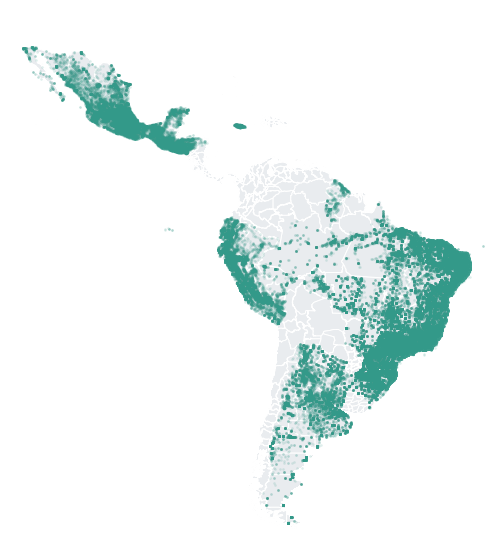

In [50]:
# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth  = 1, edgecolor = "white")
healthinfra.plot(ax = ax, color = "#339989", markersize = 3, alpha = .1)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

### 5.2. Mobile and fixed connectivity

#### Mobile connectivity

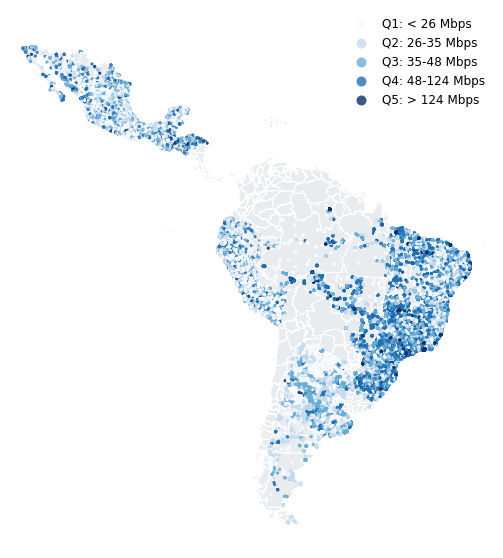

In [27]:
# Temporary variable
var_                = "avg_d_mbps_mob"
healthinfra["temp"] = qcut_label(var_)

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth  = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "temp", cmap = "Blues", categorical = True, legend = True, alpha = 0.8, markersize = 5, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

#### Fixed connectivity

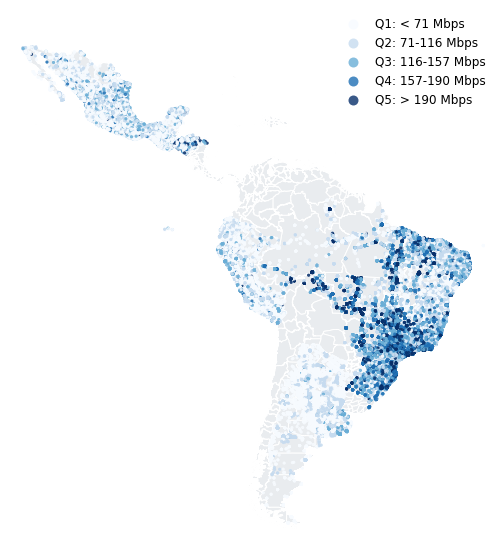

In [28]:
# Temporary variable
var_                = "avg_d_mbps_fix"
healthinfra["temp"] = qcut_label(var_)

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth  = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "temp", cmap = "Blues", categorical = True, legend = True, alpha = 0.8, markersize = 5, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

### 5.2. Health centers with or without connectivity (yes/no)

#### Mobile connectivity

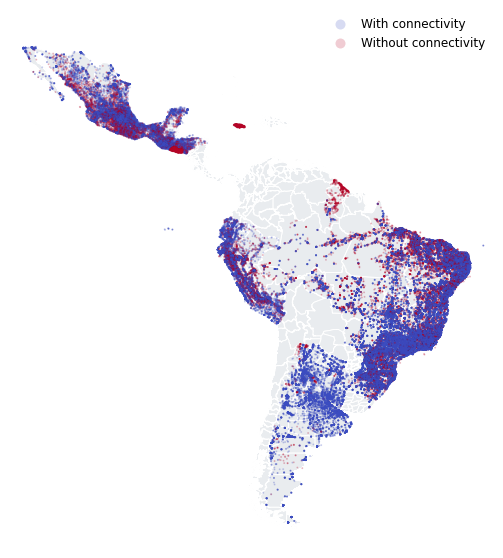

In [51]:
# Temporary variable
healthinfra["temp"] = np.where(healthinfra["connectivity_mob"] == 1, "With connectivity", "Without connectivity")

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "temp", cmap = "coolwarm", categorical = True, legend = True, alpha = 0.2, markersize = 1, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

#### Fixed connectivity

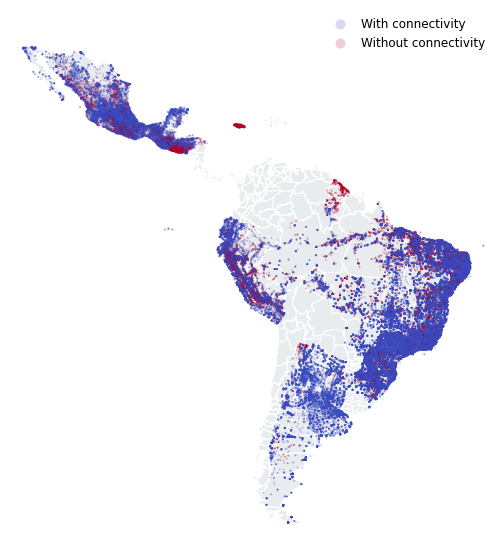

In [52]:
# Temporary variable
healthinfra["temp"] = np.where(healthinfra["connectivity_fix"] == 1, "With connectivity", "Without connectivity")

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "temp", cmap = "coolwarm", categorical = True, legend = True, alpha = 0.2, markersize = 1, legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

In [35]:
# Results
n_no_connec_mob = healthinfra.shape[0] - healthinfra.connectivity_mob.sum()
n_no_connec_fix = healthinfra.shape[0] - healthinfra.connectivity_fix.sum()
p_no_connec_mob = (n_no_connec_mob / healthinfra.shape[0]) * 100
p_no_connec_fix = (n_no_connec_fix / healthinfra.shape[0]) * 100

print(f"{n_no_connec_mob:,} ({p_no_connec_mob:.1f}%) health centers are located in areas without mobile connectivity")
print(f"{n_no_connec_fix:,} ({p_no_connec_fix:.1f}%) health centers are located in areas without fixed connectivity")
print(f"\nSource: Health centers from {healthinfra_lab} and connectivity data from Ookla Open Data Initiative, data from 2023-Q1")
print(f"Notes: A health center is considered to have connectivity if Ookla identifies at least one point with connectivity within a 5 km radius of the health center.")

22,574 (10.2%) health centers are located in areas without mobile connectivity
12,453 (5.6%) health centers are located in areas without fixed connectivity

Source: Health centers from official records and connectivity data from Ookla Open Data Initiative, data from 2023-Q1
Notes: A health center is considered to have connectivity if Ookla identifies at least one point with connectivity within a 10 km radius of the health center.


### 5.3. Health centers with low or high connectivity

#### Mobile connectivity

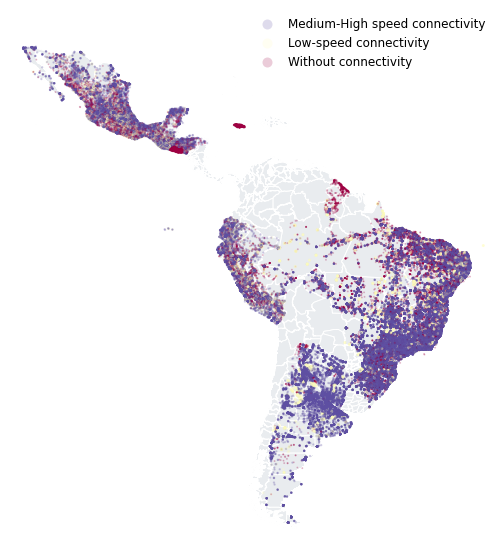

In [53]:
var_ = "avg_d_mbps_mob"
vmin = 15 
cats = ["Medium-High speed connectivity","Low-speed connectivity","Without connectivity"]

healthinfra["mtemp"] = np.where(healthinfra[var_].isna() , cats[2], "")
healthinfra["mtemp"] = np.where(healthinfra[var_] <= vmin, cats[1], healthinfra.mtemp)
healthinfra["mtemp"] = np.where(healthinfra[var_] >  vmin, cats[0], healthinfra.mtemp)
healthinfra["mtemp"] = pd.Categorical(healthinfra["mtemp"], categories = cats, ordered = True)

healthinfra["size_"] = np.where(healthinfra.mtemp == cats[2],1,0)
healthinfra["size_"] = np.where(healthinfra.mtemp == cats[1],4,healthinfra.size_)
healthinfra["size_"] = np.where(healthinfra.mtemp == cats[0],2,healthinfra.size_)

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "mtemp", cmap = "Spectral_r", categorical = True, legend = True, alpha = 0.2, markersize = "size_", legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

In [37]:
# Results 
main_ = healthinfra.mtemp.value_counts(dropna = False).reset_index()
main_ = main_.rename(columns = {"mtemp":'# health centers'})
main_["% health centers"] = main_["# health centers"] * 100 / main_["# health centers"].sum()
low_high = main_[main_["index"].isin(cats[:2])]["# health centers"].sum()
low_per  = main_[main_["index"].isin(cats[1:2])]["# health centers"].sum() / low_high

print(main_)
print(" ")
print(f"Number of healthcenters with low-high speed: {low_high:,} of which {low_per*100:.1f}% have low-speed")

print(f"\nSource: Health centers from {healthinfra_lab} and connectivity data from Ookla Open Data Initiative, data from 2023-Q1")
print(f"Notes: A health center is considered to have low and high connectivity if the average download level is less than 15 mbps.")

                            index  # health centers  % health centers
0  Medium-High speed connectivity            188166         84.820974
1            Without connectivity             22574         10.175848
2          Low-speed connectivity             11099          5.003178
 
Number of healthcenters with low-high speed: 199,265 of which 5.6% have low-speed

Source: Health centers from official records and connectivity data from Ookla Open Data Initiative, data from 2023-Q1
Notes: A health center is considered to have low and high connectivity if the average download level is less than 15 mbps.


#### Fixed connectivity

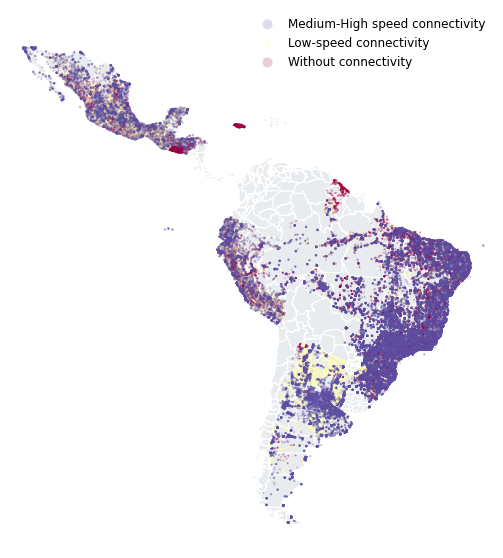

In [54]:
# Temporary variable
var_ = "avg_d_mbps_fix"
vmin = 15 
cats = ["Medium-High speed connectivity","Low-speed connectivity","Without connectivity"]

healthinfra["ftemp"] = np.where(healthinfra[var_].isna() , cats[2], "")
healthinfra["ftemp"] = np.where(healthinfra[var_] <= vmin, cats[1], healthinfra.ftemp)
healthinfra["ftemp"] = np.where(healthinfra[var_] >  vmin, cats[0], healthinfra.ftemp)
healthinfra["ftemp"] = pd.Categorical(healthinfra["ftemp"], categories = cats, ordered = True)

healthinfra["size_"] = np.where(healthinfra.ftemp == cats[2],1,0)
healthinfra["size_"] = np.where(healthinfra.ftemp == cats[1],4,healthinfra.size_)
healthinfra["size_"] = np.where(healthinfra.ftemp == cats[0],2,healthinfra.size_)

# Map 
fig, ax = plt.subplots(1, figsize = (10,10))
shp1       .plot(ax = ax, color = "#e9ecef", linewidth = 1, edgecolor = "white")
healthinfra.plot(ax = ax, column = "ftemp", cmap = "Spectral_r", categorical = True, legend = True, alpha = 0.2, markersize = "size_", legend_kwds = {'fontsize':12,'frameon':False,'loc':'upper right'})
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.axis("off")
plt.show()

In [39]:
# Results 
main_ = healthinfra.ftemp.value_counts(dropna = False).reset_index()
main_ = main_.rename(columns = {"ftemp":'# health centers'})
main_["% health centers"] = main_["# health centers"] * 100 / main_["# health centers"].sum()
low_high = main_[main_["index"].isin(cats[:2])]["# health centers"].sum()
low_per  = main_[main_["index"].isin(cats[1:2])]["# health centers"].sum() / low_high

print(main_)
print(" ")
print(f"Number of healthcenters with low-high speed: {low_high:,} of which {low_per*100:.1f}% have low-speed")

print(f"\nSource: Health centers from {healthinfra_lab} and connectivity data from Ookla Open Data Initiative, data from 2023-Q2")
print(f"Notes: A health center is considered to have low and high connectivity if the average download level is less than 15 mbps.")

                            index  # health centers  % health centers
0  Medium-High speed connectivity            199249         89.816939
1            Without connectivity             12453          5.613531
2          Low-speed connectivity             10137          4.569530
 
Number of healthcenters with low-high speed: 209,386 of which 4.8% have low-speed

Source: Health centers from official records and connectivity data from Ookla Open Data Initiative, data from 2023-Q2
Notes: A health center is considered to have low and high connectivity if the average download level is less than 15 mbps.


## 6. Table

In [41]:
%%capture
#TODO: update for efficiency 
# Health centers
hc = healthinfra.groupby(["isoalpha3"]).lat.count().reset_index()
hc = hc.rename(columns = {"lat":"# health centers"})

# Mobile 
mtab = healthinfra.groupby(["isoalpha3","mtemp"]).lat.count().reset_index()
mtab = mtab.rename(columns = {"mtemp":"temp"})
mtab["category"] = "mobile"

# Fixed
ftab = healthinfra.groupby(["isoalpha3","ftemp"]).lat.count().reset_index()
ftab = ftab.rename(columns = {"ftemp":"temp"})
ftab["category"] = "fixed"

# Total
vars_ = ["avg_d_mbps_mob","avg_d_mbps_fix"]
vmin  = 15 
cats  = ["Medium-High speed connectivity","Low-speed connectivity","Without connectivity"]

healthinfra["temp"] = np.where((healthinfra[vars_[0]].isna())  | (healthinfra[vars_[1]].isna()) , cats[2], "")
healthinfra["temp"] = np.where((healthinfra[vars_[0]] <= vmin) | (healthinfra[vars_[1]] <= vmin), cats[1], healthinfra.temp)
healthinfra["temp"] = np.where((healthinfra[vars_[0]] >  vmin) | (healthinfra[vars_[1]] >  vmin), cats[0], healthinfra.temp)
healthinfra["temp"] = pd.Categorical(healthinfra["temp"], categories = cats, ordered = True)

ttab = healthinfra.groupby(["isoalpha3","temp"]).lat.count().reset_index()
ttab["category"] = "total"

# Join 
tab          = pd.concat([mtab,ftab,ttab])
tab          = tab[["isoalpha3","category","temp","lat"]]
tab          = tab.pivot(index = "isoalpha3", columns = ["category","temp"], values = "lat")
tab          = hc.merge(tab, on = "isoalpha3", how = "left")

In [42]:
tab   

,isoalpha3,# health centers,"(mobile, Medium-High speed connectivity)","(mobile, Low-speed connectivity)","(mobile, Without connectivity)","(fixed, Medium-High speed connectivity)","(fixed, Low-speed connectivity)","(fixed, Without connectivity)","(total, Medium-High speed connectivity)","(total, Low-speed connectivity)","(total, Without connectivity)"
0,ARG,24710,23758,643,309,21714,2815,181,23994,567,149
1,BRA,151193,132438,5735,13020,143595,1761,5837,144227,1676,5290
2,ECU,2061,1578,240,243,1741,181,139,1872,110,79
3,GTM,3371,2453,481,437,2348,530,493,2814,324,233
4,GUY,389,0,0,389,0,0,389,0,0,389
5,HND,1364,1058,69,237,1055,106,203,1132,78,154
6,JAM,342,0,0,342,0,0,342,0,0,342
7,MEX,20800,13762,2535,4503,15491,3460,1849,16553,2706,1541
8,PER,16848,13119,1396,2333,13305,1284,2259,14315,983,1550
9,SLV,761,0,0,761,0,0,761,0,0,761
